# Web & Social information extraction project
Antonio Norelli

## Introduction
The goal of the project is to build a Multi-domain social recommender system based on the [WikiMID dataset](http://wikimid.tweets.di.uniroma1.it/wikimid/).

The project was developed in Jupyter, a notebook editor based on IPython. Notebook documents are both human-readable documents containing the analysis description and the results (figures, tables, etc..) as well as executable documents which can be run to perform data analysis.

IPython notebooks are becoming a standard in data analysis and are ideal for the tasks of this project. 

We use Google Colab to make the notebook runnable directly in a browser from any OS (Python code runs in cloud on a virtual machine in a google server), moreover Colab guarantees read and write access to our Google Drive where we stored the dataset. 

## Setup utilities
In this section are implemented some basic utilities (plot functions, google drive access management...)

###Google drive access
We have the datasets saved on Google Drive, Colab can access data directly from Drive without the necessity of download it in local.


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

test

In [0]:
!ls drive

### plot functions

In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12) #20, 12

def hist_from_dict(dictionary, log=False, title=None):
  if log:
    plt.yscale('log', nonposy='clip')
    plt.grid(True,which="both",ls="-", axis="y")
  if title:
    plt.title(title)
  plt.bar(range(len(dictionary)), dictionary.values(), align='center')
  plt.xticks(range(len(dictionary)), dictionary.keys(), rotation=90)
  plt.show()

Populating the interactive namespace from numpy and matplotlib


### installing and loading libraries

In [0]:
!pip install tqdm
from tqdm import tqdm
from pprint import pprint

## Load Dataset and preanalysis
In this section the dataset is loaded in a convenient form, i.e. dictionaries. Dictionaries in python are implemented as hash tables.

During the loading of the dataset it is performed a basic analysis of the data. These analysis will turn useful when choosing the more suitable method to perform subsequent tasks.

### Analyzing type of relations
There are four type of relations: follows, likes, relatedMatch, type.

In [0]:
import gzip

# data_user_wiki = {}
# data_user_categories = {}

counter = 0
counter_ok = 0
counter_no = 0
relation_occurrences = {}
with gzip.open('drive/Universita/Informatica/WebAndSocialInformationExtraction/project/Wiki-MID_EN.nt.gz', 'rt', encoding='latin-1') as f:
  try:
    for line in f:
        #print('got line', line.split())
        
        line_split = line.split()  # triple split in a list
        relation = line_split[1].split('/')[-1][:-1]
        if relation not in relation_occurrences:
          relation_occurrences[relation] = 1
          print(relation)
          print(line_split)
        else:
          relation_occurrences[relation] += 1
        
        counter += 1
        if counter == 100000000:  # numbers of triples twitterid - related to - wikipage 58789
          break
  except UnicodeDecodeError:
    print("UnicodeDecodeError at line", counter)
    pprint(relation_occurrences)

core#relatedMatch
['<https://twitter.com/intent/user?user_id=1483528441>', '<http://www.w3.org/2004/02/skos/core#relatedMatch>', '<https://en.wikipedia.org/wiki/Home_improvement>', '.']
22-rdf-syntax-ns#type
['<https://twitter.com/intent/user?user_id=100000647>', '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>', '<http://rdfs.org/sioc/ns#UserAccount>', '.']
ns#follows
['<https://twitter.com/intent/user?user_id=100000647>', '<http://rdfs.org/sioc/ns#follows>', '<https://twitter.com/intent/user?user_id=369583954>', '.']
ns#likes
['<https://twitter.com/intent/user?user_id=158311655>', '<http://rdfs.org/sioc/ns#likes>', '<http://www.imdb.com/title/tt6435884>', '.']


Let's see the frequency, we need a log scale.

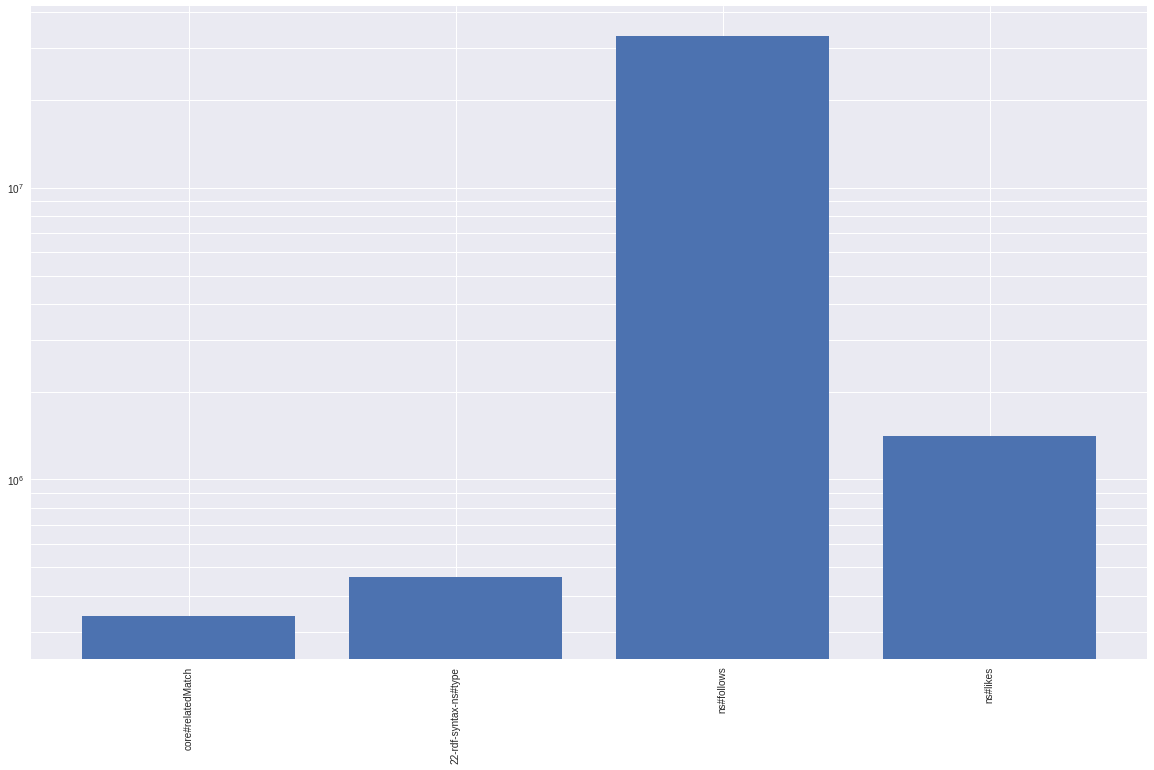

In [0]:
hist_from_dict(relation_occurrences, log=True)

### Analyzing type of subjects
With subject we refer to the first element of every triple, ignoring the relation type.
There are many types of subjects. e.g. 'https://play.spotify.com/user/', 
 'https://twitter.com/intent/', 
 'https://www.goodreads.com/book/show/'

First of all we need a simple function to extract the subject from any link. Two examples are showed.

In [0]:
def subject_scraper(url_string):
  subject_split = url_string.split('/')
  if len(subject_split) > 3 and subject_split[3][:3] == 'tit':  #title 
    subject_split = list(subject_split[:5])
  elif len(subject_split) > 5 and subject_split[5][:3] == 'pla':  # playlist
    subject_split = list(subject_split[:5])
#         elif subject_split[-1] == '>':
#           subject_split.pop()
  subject = 'https:/' + '/'.join(subject_split[1:-1]) + '/'
  return subject

print(subject_scraper('<https://twitter.com/intent/user?user_id=1483528441>'))
print(subject_scraper('<http://www.imdb.com/title/tt6840616>'))

https://twitter.com/intent/
https://www.imdb.com/title/


Let's find all the subjects and their occurrences.

In [0]:
import gzip


counter = 0
subject_occurrences = {}

with gzip.open('drive/Universita/Informatica/WebAndSocialInformationExtraction/project/Wiki-MID_EN.nt.gz', 'rt', encoding='latin-1') as f:
  for line in f:
      try:
        #print('got line', line.split())

        line_split = line.split()  # triple split in a list
        subject = subject_scraper(line_split[0])
        if subject not in subject_occurrences:
          subject_occurrences[subject] = 1
        else:
          subject_occurrences[subject] += 1

        counter += 1
        if counter == 100000000:  # numbers of triples twitterid - related to - wikipage 58789
          break
      except UnicodeDecodeError: 
        print("UnicodeDecodeError at line", counter)
        print(line)

pprint(subject_occurrences)

{'https://': 1,
 'https://goodreads.com/review/show/': 10236,
 'https://open.spotify.com/album/': 12808,
 'https://open.spotify.com/artist/': 1760,
 'https://open.spotify.com/concert/': 5,
 'https://open.spotify.com/episode/': 29,
 'https://open.spotify.com/show/': 25,
 'https://open.spotify.com/track/': 73661,
 'https://open.spotify.com/user/': 4008,
 'https://play.spotify.com/album/': 7,
 'https://play.spotify.com/artist/': 2,
 'https://play.spotify.com/track/': 63,
 'https://play.spotify.com/user/': 12,
 'https://spoti.fi/': 160926,
 'https://twitter.com/intent/': 35002172,
 'https://www.goodreads.com/book/show/': 69,
 'https://www.goodreads.com/review/': 6879,
 'https://www.goodreads.com/review/show/': 3526,
 'https://www.imdb.com/title/': 8282}


Let's see the frequencies. It is clear the prevalence of the music topic in this dataset, we will see later how this evidence affects the design of the reccomendation system.

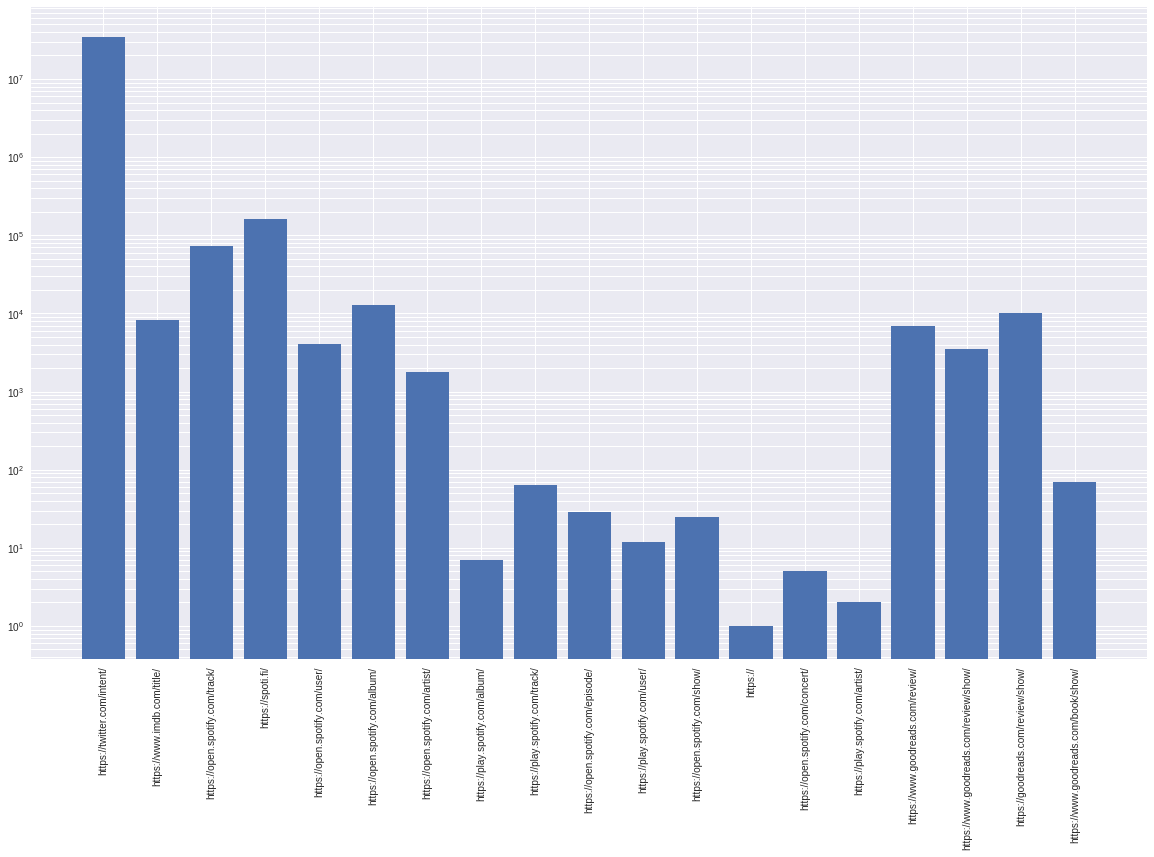

In [0]:
id_subject = {}  # every type of subject has a different id
subject_id = {}
keys_to_be_removed = []
counter = 0
for key, value in subject_occurrences.items():
  if value > 0:  #1: # and key[8:10] != 'tw':
    counter += 1
    id_subject[counter] = key
    subject_id[key] = counter
  else:
    keys_to_be_removed.append(key)
    
for key in keys_to_be_removed:
  subject_occurrences.pop(key)

hist_from_dict(subject_occurrences, log=True) 
# pprint(subject_id)
  

### Building dataset in dictionaries
Let's put the dataset in a convenient form. The name of every dictionary follows the standard *key_value*.

e.g. ```
interest_wiki, 
interest_interesttypeid, 
user_interests, 
user_wikipages, 
numberofinterests_occurrences```



#### load data
In case you have stored the data already parsed.

In [0]:
# SAVE/LOAD THINGS

# load_data = False #@param {type:"boolean"}

# import pickle
# if load_data:
#   en_embedding = pickle.load(open( "drive/Universita/Informatica/WebAndSocialInformationExtraction/project/en_embedding.pickle", "rb" ))
#   interest_wiki = pickle.load(open( "drive/Universita/Informatica/WebAndSocialInformationExtraction/project/interest_wiki.pickle", "rb" ))
#   user_wikipages = pickle.load(open( "drive/Universita/Informatica/WebAndSocialInformationExtraction/project/user_wikipages.pickle", "rb" ))
# else:
#   pickle.dump(en_embedding, open( "drive/Universita/Informatica/WebAndSocialInformationExtraction/project/en_embedding.pickle", "wb" ) )
#   pickle.dump(interest_wiki, open( "drive/Universita/Informatica/WebAndSocialInformationExtraction/project/interest_wiki.pickle", "wb" ))
#   pickle.dump(user_wikipages, open( "drive/Universita/Informatica/WebAndSocialInformationExtraction/project/user_wikipages.pickle", "wb" ))

#### compute data
We need a function that extract a unique id from every link. We may use directly the link but this would be less memory efficient and computationally efficient when comparing ids. 

In [0]:
def id_scraper(url_string):
  for  counter, character in enumerate(reversed(url_string)):
    if character == '/' or character == '=':
      return url_string[-counter:-1]
    
print(id_scraper('<https://twitter.com/intent/user?user_id=1483528441>'))
print(id_scraper('<https://www.goodreads.com/book/show/22856899-the-tribute-bride>'))

1483528441
22856899-the-tribute-bride


building of ```
interest_wiki, interest_interesttypeid, user_interests
```



In [0]:
counter = 0

interest_wiki = {}
interest_interesttypeid = {}
user_interests = {}

with gzip.open('drive/Universita/Informatica/WebAndSocialInformationExtraction/project/Wiki-MID_EN.nt.gz', 'rt', encoding='latin-1') as f:
  for line in f:
      try:
        line_split = line.split()  # triple split in a list
        if line_split[1][-2] == 'h':  #Related#Match
          interest_id = id_scraper(line_split[0])
          wiki_page = id_scraper(line_split[2])
          interest_wiki[interest_id] = wiki_page
          
          interest_type = subject_scraper(line_split[0])
          interest_interesttypeid[interest_id] = subject_id[interest_type]
        elif line_split[1][-2] == 's':  #likes or follows
          user_id = id_scraper(line_split[0])
          interest_id = id_scraper(line_split[2])
          if user_id in user_interests:
            user_interests[user_id].append(interest_id)
          else:
            user_interests[user_id] = [interest_id]

      except UnicodeDecodeError: 
        print("UnicodeDecodeError at line", counter)
        print(line)

With `user_interests` we can now build `user_wikipages` and `numberofinterests_occurrences`. Not all the interests has a corresponding wikipage, it is showed the fraction of times the wiki page corrsponding to an interest is missing.

In [0]:
user_wikipages = {}
numberofinterests_occurrences = {i: 0 for i in range(1, 10000)}
missing_keys = {}
present_keys = {}

for counter, key in enumerate(user_interests):
  wikipages = []
  for interest in user_interests[key]:
    try:
      wikipages.append(interest_wiki[interest])
      present_keys[key] = True
    except KeyError:
      missing_keys[key] = True
  if wikipages:    
    user_wikipages[key] = wikipages
    numberofinterests_occurrences[len(wikipages)] += 1

print('fraction of times the wiki page corrsponding to an interest is missing', len(missing_keys)/(len(missing_keys) + len(present_keys)))

fraction of times the wiki page corrsponding to an interest is missing 0.3297097450612515


let's see a sample of the dictionaries.

In [0]:
def dictionary_sample(dictionary, n=7):
  return {k: dictionary[k] for k in list(dictionary)[:n]}

In [0]:
print(dictionary_sample(interest_wiki))
print(dictionary_sample(interest_interesttypeid))
print(dictionary_sample(user_interests))
print(dictionary_sample(user_wikipages))
print(dictionary_sample(numberofinterests_occurrences))

{'1483528441': 'Home_improvement', '531482104': 'Conor', '203055763': 'Oliver_Cheshire', '207381263': 'Travis_Snider', '7078822': 'Hot_Hot_Heat', '15922651': 'David_Weiner', '368563911': 'Jaime'}
{'1483528441': 1, '531482104': 1, '203055763': 1, '207381263': 1, '7078822': 1, '15922651': 1, '368563911': 1}
{'100000647': ['369583954', '41110545', '82097756', '62513246', '108037973', '70722719', '1925157330', '361812003', '20505679', '3385716183', '525229552', '118409104', '21356261', '413485609', '75916180', '2493431251', '27260086', '166215202', '153474021', '61052617', '1542533869', '19650780', '152060185', '48356337', '527526077', '558109036', '278103138', '14222536', '221122127', '191111643', '200050704', '369661956', '1336408873', '20908109', '268414482', '601813540', '17540485', '338084918', '19551069', '23762505', '22838300', '224267898', '25489250', '95553167', '268182030', '21568477', '113613920', '19661294', '20940081', '89831997', '15253147', '97837399', '19562228', '18863815'

How many interests for each user?

Number of users 425145


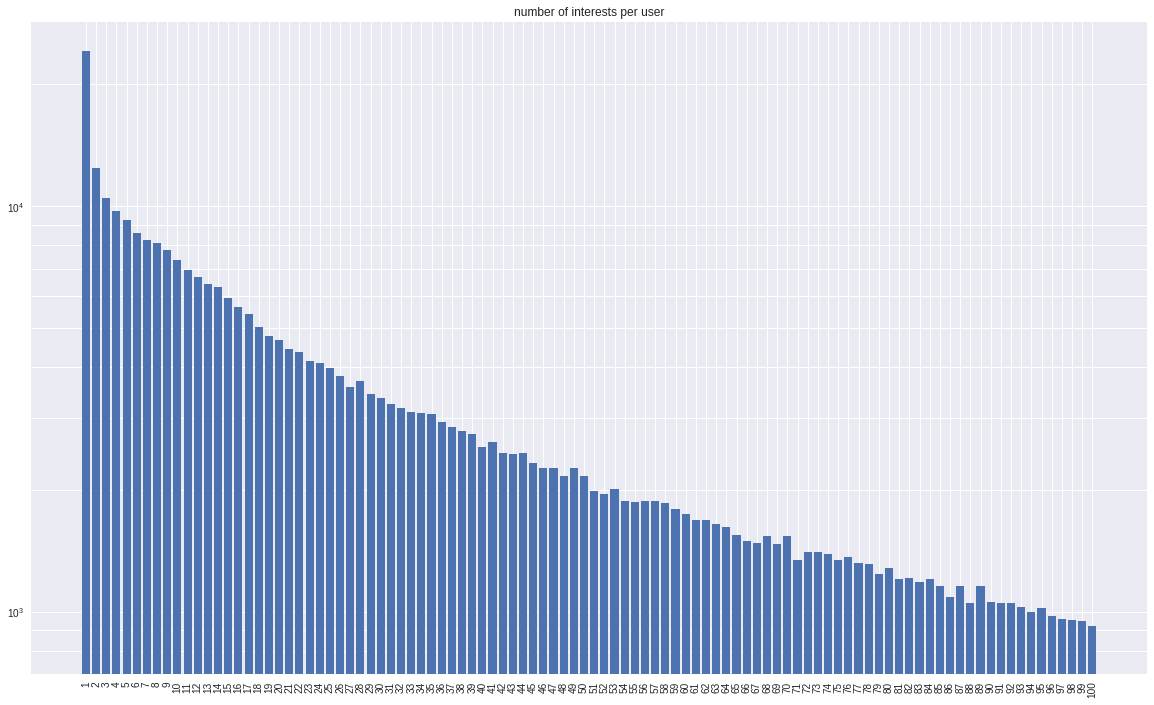

In [0]:
print("Number of users", len(user_wikipages))
hist_from_dict(dictionary_sample(numberofinterests_occurrences, n=100), log=True, title='number of interests per user')

## 1. Categories from interests
Extracting categories to syntethize interests using semantic is not a well defined problem, how can we measure the performance of our approach? We should make some assumptions:

1. Each interest should be semantically related to its category
2. Categorization should be balanced
3. Granularity should be appropriate: too many categories are redundant, too few categories weaken the model due to the loss of information.

The balance of the categorization is an easy measure but what about the other two criteria?

Let's see our approach to the problem.

We used [precomputed wikipage embeddings ](https://meta.wikimedia.org/wiki/Research:Wikipedia_Navigation_Vectors)as semantic model, these are obtained applying Wor2vec algorithm to reading sessions (sequence of articles visited by a user during a wikipedia session), where articles that tend to be read in close succession have similar representations. Since people usually generate sequences of semantically related articles while reading, these embeddings also capture semantic similarity between articles.
Each vector has 100 dimensions.

We select all vectors corresponding to wikipedia articles present in the WikiMID dataset (216.000 out of 1.828.000) and perform a clusterization using MiniBatch K-Means, Minibatch because of the size of the dataset, K-Means because it is more prone to generate balanced clusters and the number of clusters is tunable. However clustering suffers from the curse of dimensionality and 100 dimensions are too much, so we performed at first a dimensionality reduction with PCA, the final number of dimensions is chosen looking at the explained variance, 6 dimensions in our case.

The number of clusters is decided looking both at the silhouette coefficient (look below for more details) and at the semantic range of categories (we do not want too few clusters even if the corresponding silhouette coefficient is high, all the categories would be about music).

The final clusters represents the categories, we named each category looking at the centroid of the cluster, the name follows the standard: *Macrocategory (Centroid page name)*. Where Macrocategory refers to the category of the centroid page in Babelnet (e.g. Music, Literature and Theatre...). The simple Babelnet categorization is not good because led to a heavy unbalanced categorization, for instance Music would include more than 60% of all the pages. With our method instead we have many music categories, distinguished by the centroid page name, e.g. Music (Blind_Melon), Music (Yo_Gotti)... This partition of the categories is meaningful, for instance Music (Blind_Melon) can be associated to USA Rock, while Music (Yo_Gotti) to Rap.


### Importing Wikipage embeddings
Wikipage embeddings are managed with the WikiEmbedding class as suggested by the [official documentation](https://github.com/ewulczyn/wiki-vectors/blob/master/src/Wikipedia%20Navigation%20Vectors%20-%20Getting%20Started.ipynb).

WikiEmbedding class implements two methods: 
- most_similar returns the n most similar wikipages to a given one using cosine similarity
- wiki_vector returns the vector corresponding to a given wikipage (implemented by us)

In [0]:
import numpy as np
from sklearn.preprocessing import normalize
import requests
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


class WikiEmbedding:

    def __init__(self, fname=None, preset=None):
      
      if preset:
        self.E, self.w2idx, self.idx2w = preset
      
      elif fname:              
        self.w2idx = {}
        self.idx2w = []
    
        with open(fname, 'rb') as f:
            
            m, n = next(f).decode('latin-1').strip().split(' ')
            self.E = np.zeros((int(m), int(n)))

            for i, l in enumerate(f):
                l = l.decode('latin-1').strip().split(' ')
                w = l[0]
                self.E[i] = np.array(l[1:])
                self.w2idx[w] = i
                self.idx2w.append(w)
                
        self.E = normalize(self.E)
        self.idx2w = np.array(self.idx2w)
      else:
        print('InputError: no input data')

    def most_similar(self, w, n=10, min_similarity=0.5):
        """
        Find the top-N most similar words to w, based on cosine similarity.
        As a speed optimization, only consider neighbors with a similarity
        above min_similarity
        """
        
        if type(w) is str:
            w = self.E[self.w2idx[w]]

        scores = self.E.dot(w)
        # only consider neighbors above threshold
        min_idxs = np.where(scores > min_similarity)
        ranking = np.argsort(-scores[min_idxs])[1:(n+1)]
        nn_ws = self.idx2w[min_idxs][ranking]
        nn_scores = scores[min_idxs][ranking]
        return list(zip(list(nn_ws), list(nn_scores)))
    
    def wiki_vector(self, w):
      return self.E[self.w2idx[w]]

In [0]:
en_embedding = WikiEmbedding('drive/Universita/Informatica/WebAndSocialInformationExtraction/project/2017-01-01_2017-01-30_en_100')


test

In [0]:
pprint(en_embedding.most_similar('Free_Territory_of_Trieste'))
pprint(en_embedding.wiki_vector('Free_Territory_of_Trieste'))



[('Treaty_of_Osimo', 0.8323037256371111),
 ('Treaty_of_Peace_with_Italy,_1947', 0.800103219631803),
 ('Julian_March', 0.797425343595012),
 ('Imperial_Free_City_of_Trieste', 0.7865059572524098),
 ('Italyâ\x80\x93Yugoslavia_relations', 0.7827815260787903),
 ('Trieste', 0.7825667740594515),
 ('Communist_Party_of_the_Free_Territory_of_Trieste', 0.7780288050214144),
 ('Province_of_Trieste', 0.7776574513692992),
 ('Governorate_of_Dalmatia', 0.7710054317274165),
 ('State_of_Slovenes,_Croats_and_Serbs', 0.7709420334855925)]
array([-8.48096470e-02,  5.08477744e-02,  4.54026219e-02, -1.06773494e-01,
       -8.36872873e-02,  3.32047678e-02,  1.32554829e-01,  9.87432548e-02,
       -6.96468114e-02, -8.05215010e-02,  1.86604988e-01,  1.53296768e-01,
       -1.37440265e-02,  3.54736424e-02,  1.30684148e-02,  9.55562412e-02,
        1.12241094e-01,  6.35182395e-03,  8.83287327e-02,  2.65917757e-01,
       -2.90803399e-02, -2.23796085e-02,  1.48023629e-01, -6.61289457e-03,
        6.73330425e-02,  2.9

#### Building wikiembeddings of wikipages representing interests
Selection of the Wikipages corresponding to an interest. A new WikiEmbedding object is created.

Some pages are not found, the problem is especially with pages that needs a disambiguation. WikiMID dataset and official Wikipage embeddings make use of a different naming standard for those pages.

In [0]:
def wikiembedding_from_wikipages(wikipages, wikiembedding, verbose=1):
  E = []
  w2idx = {}
  idx2w = []
  counter = 0
  not_found_counter = 0
  for page in wikipages:
    try:
      E.append(wikiembedding.wiki_vector(page))
      w2idx[page] = counter
      idx2w.append(page)
      counter += 1
    except KeyError:
      if verbose > 1:
        if not_found_counter < 10:
          print(page, "not found")
      not_found_counter += 1
  if verbose:
    print(round(not_found_counter / (counter + not_found_counter), 2), 'fraction of pages not found (', str(not_found_counter), ')')
  return(np.array(E), w2idx, np.array(idx2w))

Fraction of the pages noit found and the final size of the original wiki embedding compared with the selection of only the interests wikiembedding

In [0]:
en_embedding_interests = WikiEmbedding(preset = wikiembedding_from_wikipages(list(interest_wiki.values()), en_embedding))
print('interests embedding size', en_embedding_interests.E.shape)
print('original embedding size', en_embedding.E.shape)

0.36 fraction of pages not found ( 122188 )
interests embedding size (216686, 100)
original embedding size (1828514, 100)


reducing dimensionality with PCA, we choose 6 dimensions after some tuning.

In [0]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_dimensions = 6 #@param {type:"slider", min:2, max:100, step:1}
pca = PCA(n_components=pca_dimensions)
reduced_vector = pca.fit_transform(en_embedding_interests.E)

In [0]:
expl_var = pca.explained_variance_
print("explained variance, sum =", sum(expl_var), expl_var)

explained variance, sum = 0.19369963126390444 [0.04800919 0.03587111 0.03232774 0.02849503 0.0256231  0.02337347]


How many clusters? Let's see manually meaningfulness and granularity of results and take a look to the Silhouette coefficient trend for a range of cluster from 2 to 70. Silhouette coefficient is explained later.

In [0]:
from sklearn.cluster import Birch, MiniBatchKMeans
from time import time
from sklearn.metrics import silhouette_score

In [0]:
inertia_log = []
sil_log = []

for ncl in range(2, 70, 1):
  X = reduced_vector #en_embedding_interests.E
  mbk = MiniBatchKMeans(init='k-means++', n_clusters=ncl, batch_size=100, # 80, 1000
                        n_init=10, max_no_improvement=10, verbose=0,
                        random_state=0)
#   t0 = time()
  mbk.fit(X)
#   t_mini_batch = time() - t0
#   print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
  inertia_log.append((ncl, mbk.inertia_))
  silhouette_avg = silhouette_score(X, mbk.labels_, sample_size=10000)
  print('inertia with', ncl, 'clusters:', mbk.inertia_, 'the silhouette score is:', silhouette_avg)
#   mbk_means_labels_unique = np.unique(mbk.labels_)
  inertia_log.append((ncl, mbk.inertia_))
  sil_log.append((ncl, silhouette_avg))

inertia with 2 clusters: 33958.114153170114 the silhouette score is: 0.1945606554810355
inertia with 3 clusters: 29384.852583354022 the silhouette score is: 0.21667831652906902
inertia with 4 clusters: 25080.14959892296 the silhouette score is: 0.22716053342831033
inertia with 5 clusters: 22282.939896890704 the silhouette score is: 0.23579468452503446
inertia with 6 clusters: 20182.258137762805 the silhouette score is: 0.24278501874096586
inertia with 7 clusters: 18341.80680665186 the silhouette score is: 0.22245983383754742
inertia with 8 clusters: 17791.78756395901 the silhouette score is: 0.20446334796081986
inertia with 9 clusters: 16759.66110933048 the silhouette score is: 0.20667360379759092
inertia with 10 clusters: 16259.1088885072 the silhouette score is: 0.19117683073614758
inertia with 11 clusters: 15627.10148213353 the silhouette score is: 0.19915564581881465
inertia with 12 clusters: 14865.901135102871 the silhouette score is: 0.19310366501855106
inertia with 13 clusters: 

Inertia (sum of all squared distance from the closest centroid) decreases naturally as the number of cluster increases. It is worth to look at the inertia trend to check any second order singularities, those may correspond to a  good choice for the number of clusters. In our case however the trend is smooth without any "elbow". 

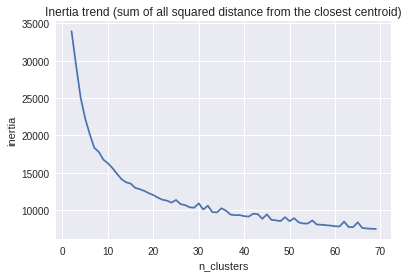

In [0]:
plt.plot([i[0] for i in inertia_log], [i[1] for i in inertia_log])
plt.ylabel('inertia')
plt.xlabel('n_clusters')
plt.title('Inertia trend (sum of all squared distance from the closest centroid)')
plt.show()

The Silhouette trend is more interesting.

The Silhouette coefficient is a measure to evaluate clustering that does not need ground truth labels, it is based on how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

We used sklearn implementation of the silhouette score defined as follows:

The Silhouette Coefficient is defined for each sample and is composed of two scores:

- **a**: The mean distance between a sample and all other points in the same class.
- **b**: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient *s* for a single sample is then given as:

$$s = \frac{b - a}{max(a, b)}$$

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

We used euclidean distance.

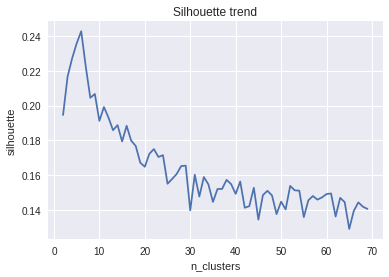

In [0]:
plt.plot([i[0] for i in sil_log], [i[1] for i in sil_log])
plt.ylabel('silhouette')
plt.xlabel('n_clusters')
plt.title('Silhouette trend')
plt.show()

Despite few clusters guarantee an higher Silhouette coeficient we choose 41 clusters that provide a sufficient granularity and is near a local maximum of the Silhouette trend.

In [0]:
n_clusters_cat = 41 #@param {type:"slider", min:2, max:70, step:1}

So we perform the final clustering.

In [0]:
X = en_embedding_interests.E
mbk_cat = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters_cat, batch_size=100, # 80, 1000
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
t0 = time()
mbk_cat.fit(X)
t_mini_batch = time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk_cat.labels_)

Time taken to run MiniBatchKMeans 5.11 seconds


Now we have to name the categories, as described above we make use of the Babelnet domains. This is accomplished using two files, a sample of each one is showed below.

As said before the rough categorization with babelnet domains led to poor results due to the heavy unbalance with our dataset. And the high number of missing wikipages.

We used two official sources of Babelnet:

*babeldomains_wiki.txt* with the category associated to each wikipage and the corresponding confidence score.

```
2010 Proton Malaysian Open – Singles	Sport and recreation	1.0
Promnik, Masovian Voivodeship	Geography and places	1.0
Mark Rankin (record engineer)	Music	1.0
Conformal film	Chemistry and mineralogy	1.0
```

*domain_list.txt* with all the domains (categories) listed


```
Animals
Art, architecture, and archaeology
Biology
Business, economics, and finance
Chemistry and mineralogy
Computing
Culture and society
Education
Engineering and technology
Farming
Food and drink
Games and video games
Geography and places
Geology and geophysics
Health and medicine
Heraldry, honors, and vexillology
History
Language and linguistics
Law and crime
Literature and theatre
Mathematics
Media
Meteorology
Music
Numismatics and currencies
Philosophy and psychology
Physics and astronomy
Politics and government
Religion, mysticism and mythology
Royalty and nobility
Sport and recreation
Textile and clothing
Transport and travel
Warfare and defense
```




In [0]:
data_wiki_category = {}
category_occurrences = {}

with open('drive/Universita/Informatica/WebAndSocialInformationExtraction/project/babeldomains_wiki.txt', 'r') as f:
  for line in tqdm(f):
    line_split = line.split('\t')
    data_wiki_category[line_split[0]] = line_split[1]    

with open('drive/Universita/Informatica/WebAndSocialInformationExtraction/project/domain_list.txt', 'r') as f:
  for line in tqdm(f):
    category_occurrences[line[:-1]] = 0  

2386326it [00:07, 312955.81it/s]
34it [00:00, 38.25it/s]


Finally we have the categories with their human understandable names. Since not all wikipages are present in *babeldomains_wiki.txt*, if the centroid is missing we deduce the macrocategory from the first present close neighbor.

In [0]:
# printing cluster centroids
idcategory_category = {}
flag_found = 0
for i, centroid in enumerate(mbk_cat.cluster_centers_):
  similars = en_embedding.most_similar(centroid, n=5000, min_similarity=0.01)
  most_similar = similars[0][0]
  for n, near_centroid in enumerate(similars):
    if near_centroid[0] in data_wiki_category:
      print(i, data_wiki_category[near_centroid[0]] + ' (' + most_similar + ')' + '\t from ' + near_centroid[0] + ' pos', n)
      flag_found = 1
      idcategory_category[i] = data_wiki_category[near_centroid[0]] + ' (' + most_similar + ')'
      break
  if not flag_found:
    print(i, ' (' + most_similar + ')')
  else:
    flag_found = 0

0 Music (Humble_Pie_(band))	 from Foghat pos 40
1 Music (Blind_Melon)	 from Soundgarden pos 1
2 Music (Live_from_the_Ghetto)	 from G-Unit pos 18
3 Literature and theatre (A_Night_to_Surrender)	 from Dragonhaven pos 84
4 Music (List_of_awards_and_nominations_received_by_Sugababes)	 from Adele pos 7
5 Music (Y.BIRD_from_Jellyfish_Island_With_Seo_In_Guk)	 from TVXQ pos 18
6 Music (Martin_O'Donnell)	 from Audiomachine pos 13
7 Music (Saosin)	 from Saosin pos 0
8 Music (Groove_Armada)	 from Moloko pos 6
9 Music (Josh_Turner)	 from Sugarland pos 52
10 Music (Give_My_Regards_to_Broad_Street)	 from Thrillington pos 77
11 Music (Emma_Myles)	 from Godspell pos 182
12 Music (Shuvel)	 from Korn pos 3
13 Language and linguistics (Eliana)	 from Jaelyn pos 20
14 Music (Waiting_for_the_Floods)	 from Ultravox pos 1
15 Music (A_New_Chance)	 from Tomlab pos 11
16 Music (42nd_GMA_Dove_Awards)	 from MercyMe pos 6
17 Music (Progressive_house)	 from Showtek pos 6
18 Sport and recreation (Darrell_Currie)	 fro

### Example of a user
In this subsection we tried our categorization method with a single user to have a feedback.
Below are showed the processing and the results.

##### TSNE plot code
With a single user we can plot the wikipage vectors corresponding to interests, in this way we can see if the distance between them has a semantic meaning. So we can have an idea of the performance of the chosen semantic model.

Our plot should be in two dimensions, so we use TSNE algorithm after PCA to reduce further the dimensionality. TSNE is the standard for this type of data visualization.

In [0]:
def get_tsne(embedding, pca_dim = 20, n_items=10000, small_embedding=None):
    """
    TSNE dimensionality reduction.
    
    The TSNE algorithm is quite slow, so we:
    
    1. only use the first n_items from the embedding
    2. reduce embedding dimensionality via PCA
    3. run TSNE on reduced embedding matrix
    
    """
    if small_embedding:
      X = np.concatenate((small_embedding.E, embedding.E[:n_items]))
      #print(np.array(small_embedding.E).shape, X.shape)
    else:
      X = embedding.E[:n_items]
    pca = PCA(n_components=pca_dim)
    X = pca.fit_transform(X)
    tsne = TSNE(n_components=2, random_state=0)
    return tsne.fit_transform(X)



def repel_labels(ax, x, y, labels, k=10):
    """
    Helper code for making a readable scatter plot: See:
    https://stackoverflow.com/questions/14938541/how-to-improve-the-label-placement-for-matplotlib-scatter-chart-code-algorithm
    """
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        ax.annotate(label,
                    xy=pos[data_str], xycoords='data',
                    xytext=pos[label], textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='red'), )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])

def plot_tsne(embedding, tsne, n=20, small_embedding=None, k=10):
    """
    Create a scatter plot for the first
    n words in embedding using tsne representation
    """
    if small_embedding:
      n = len(small_embedding.E)
      labels = small_embedding.idx2w[:n]
    else:
      labels = embedding.idx2w[:n]
#     pprint(np.array(small_embedding.idx2w[:n]).shape)
#     pprint(embedding.idx2w[:n].shape)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(tsne[:n, 0], tsne[:n, 1])
    repel_labels(ax, tsne[:n, 0], tsne[:n, 1], labels, k=k)
    plt.show()
    fig.savefig('embedding.png')


def plot_tsne_simple(embedding, tsne):
    plt.figure(figsize=(8, 8))
    for i in range(20):
        x, y = tsne_embedding[i,:]
        plt.scatter(x, y)
        plt.annotate(embedding.idx2w[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

##### Selecting a user with 25 interests
We look for a user with a sufficient range of interests.

In [0]:
for key in user_wikipages:
  if len(user_wikipages[key]) == 25:
    sample_wiki_list = user_wikipages[key]
    break

en_embedding_user = WikiEmbedding(preset = wikiembedding_from_wikipages(sample_wiki_list, en_embedding_interests))

Cin%C3%A9polis not found
Tyler%2C_The_Creator not found
0.08 fraction of pages not found


In [0]:
tsne_en_embedding = get_tsne(en_embedding_interests, pca_dim = 10, n_items=5000, small_embedding=en_embedding_user)

This is the plot. Results are very good, we can easily distinguish three clusters: Sport, Cinema, Music. Even the location of elements in a single cluster appears strongly semantically meaningful. Look at the Sport cluster, all instances related to Real Madrid are very close while New England Patriots is more distant.

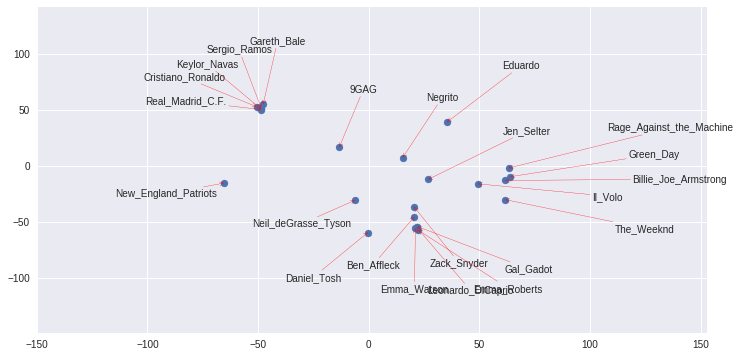

In [0]:
arrow_size = 21 #@param {type:"slider", min:1, max:100, step:1}
plot_tsne(en_embedding, tsne_en_embedding, small_embedding=en_embedding_user, k=arrow_size)

Below are showed the elements most similar to Cristano Ronaldo inside the user interests.

In [0]:
pprint(en_embedding_user.most_similar('Cristiano_Ronaldo', n=10, min_similarity=0))

[('Gareth_Bale', 0.861935873465163),
 ('Sergio_Ramos', 0.8490769847592015),
 ('Real_Madrid_C.F.', 0.823372014072481),
 ('Keylor_Navas', 0.769464261036644),
 ('Eduardo', 0.512091795320242),
 ('9GAG', 0.4643334584321524),
 ('Leonardo_DiCaprio', 0.4310935926104691),
 ('Jen_Selter', 0.4310021568355299),
 ('The_Weeknd', 0.4180912948597736),
 ('Emma_Watson', 0.3955561288485602)]


This is the final categorization. Look how all the Real Madrid related elements and New England Patriots are in two different Sport and Recreation categories. One concerning football (Darrell Curie) and the other american football (Tyson_Chandler_(American_football)).

In [0]:
for key in en_embedding_user.w2idx:
  idcat = mbk_cat.labels_[en_embedding_interests.w2idx[key]]
  print(key, '\t', idcat, idcategory_category[idcat])

Ben_Affleck 	 27 Media (Rotten_Tomatoes)
Gal_Gadot 	 27 Media (Rotten_Tomatoes)
Keylor_Navas 	 18 Sport and recreation (Darrell_Currie)
Eduardo 	 13 Language and linguistics (Eliana)
9GAG 	 21 Business, economics, and finance (Desk.com)
Leonardo_DiCaprio 	 27 Media (Rotten_Tomatoes)
The_Weeknd 	 30 Music (Yo_Gotti)
Neil_deGrasse_Tyson 	 34 Law and crime (Fan_Gang)
Zack_Snyder 	 6 Music (Martin_O'Donnell)
New_England_Patriots 	 26 Sport and recreation (Tyson_Chandler_(American_football))
Daniel_Tosh 	 19 Media (Live_from_E!)
Jen_Selter 	 19 Media (Live_from_E!)
Negrito 	 13 Language and linguistics (Eliana)
Emma_Roberts 	 27 Media (Rotten_Tomatoes)
Gareth_Bale 	 18 Sport and recreation (Darrell_Currie)
Emma_Watson 	 27 Media (Rotten_Tomatoes)
Sergio_Ramos 	 18 Sport and recreation (Darrell_Currie)
Green_Day 	 33 Music (Rancid_(band))
Il_Volo 	 4 Music (List_of_awards_and_nominations_received_by_Sugababes)
Billie_Joe_Armstrong 	 33 Music (Rancid_(band))
Cristiano_Ronaldo 	 18 Sport and r

#### A final test for the semantic model
A final test for our semantic model, can we do simple operations like the classical word2vec?

In the classical word2vec we have:
$$most\,similar(KING - MEN + WOMAN) = QUEEN$$

The answer is yes:

$$most\,similar(CRISTIANO\,RONALDO - REAL\,MADRID + AC\,MILAN) = FILIPPO\,INZAGHI$$

In [0]:
pprint(en_embedding.most_similar(en_embedding.wiki_vector('Cristiano_Ronaldo') - en_embedding.wiki_vector('Real_Madrid_C.F.') + en_embedding.wiki_vector('A.C._Milan'), n=10, min_similarity=0))

[('Filippo_Inzaghi', 0.858675893659155),
 ('Gianluigi_Buffon', 0.8551937289213458),
 ('Gianluigi_Donnarumma', 0.8529115350039593),
 ('A.C._Milan', 0.851133389930133),
 ('Paolo_Maldini', 0.848259267609784),
 ('Roberto_Baggio', 0.8376991494947621),
 ('Ã\x89der_(Italian_footballer)', 0.8358644602974203),
 ('Inter_Milan', 0.8338901934678868),
 ('Leonardo_Bonucci', 0.8300681995189008),
 ('Cristiano_Ronaldo', 0.8261402524514764)]


### Building user-categories dictionary
Finally we build the user_categories dictionary.

In [0]:
user_categories = {}

counter = 0
not_found_counter = 0
user_with_at_least_a_category = False

for user in tqdm(user_wikipages):
  wikipages = user_wikipages[user]
  categories = [0] * n_clusters_cat
  for wikipage in wikipages:
    if wikipage in en_embedding_interests.w2idx:  # if the wikipage has a corresponding vector
      idcat = mbk_cat.labels_[en_embedding_interests.w2idx[wikipage]]
      categories[idcat] += 1
      counter += 1
      user_with_at_least_a_category = True
    else:
      not_found_counter += 1
  if user_with_at_least_a_category:
    user_categories[user] = np.array(categories)
  user_with_at_least_a_category = False

print('\nratio of wikipages without a corresponding vector', not_found_counter / (counter + not_found_counter))
    

100%|██████████| 425145/425145 [00:34<00:00, 12307.35it/s]


ratio of wikipages without a corresponding vector 0.10145143061445294


## 2. Generating clusters of similar users
At this point each user is represented by a 41 dimensional vector where each component represents the occurrences of the correspondent category.

Which community detection method should we use with this data?

We do not have a graph representation of our users, we could generate a simple graph representation using for instance cosine similarity (not sensible to the unbalanced norm of our user-vectors) and putting a similarity threshold to have a link between two nodes (users). However this is not ideal for the high computational cost due to the size of our dataset and the loss of information. So we discard community detection methods based on a graph representation.

So we look for a classical clustering method. Our attention is focused on two clustering algorithms: DBSCAN that is a good choice for non-flat geometry and can use cosine similarity and the classical KMeans that can work effectively on big datasets in its Minibatch version and gives more guarantees on the cluster's balancing. See [here](http://scikit-learn.org/stable/modules/clustering.html) for more details on the clustering algorithms (sklearn user guide).

Finally we decided newly for Minibatch Kmeans after some experiments.





### DBSCAN clustering with cosine similarity

In [0]:
# from sklearn.cluster import DBSCAN
# from sklearn import metrics

# #X = en_embedding_user.E
# X = np.array(list(user_categories.values()))[:10000]
# print(X.shape)
# max_sil = -1

# for epsint in range(5, 40, 5):
#   for min_samples in range(2, 10, 1):
#     eps = epsint/100.
#     db = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(X) # 0.5, 2

#     labels = db.labels_

#     # Number of clusters in labels, ignoring noise if present.
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     print('\n\neps', eps, 'min_samples', min_samples)
#     print('Estimated number of clusters: %d' % n_clusters_)
#     if n_clusters_ > 1:
#       sil = metrics.silhouette_score(X, labels)
#       if sil > max_sil:
#         max_sil = sil
#         print('######################################')
#       print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

In [0]:
# db = DBSCAN(eps=0.05, min_samples=8, metric='cosine').fit(X) # 0.5, 2

# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# print('\n\neps', 0.05, 'min_samples', 8)
# print('Estimated number of clusters: %d' % n_clusters_)
# if n_clusters_ > 1:
#   sil = metrics.silhouette_score(X, labels)
#   if sil > max_sil:
#     max_sil = sil
#     print('######################################')
#   print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

### Kmeans with euclidean distance
Kmeans requires some preprocessing in order to use properly the euclidean distance, that becomes almost meaningless in high dimensional spaces and with heavy unbalanced norms as our dataset.

So we perform a normalization and a PCA dimension reduction.

Note that using different metrics in Kmeans is not correct, it may stop converging with other distance functions. There exist algorithms based on the Kmeans idea that work with other distance function (e.g. Kmedians for Manhattan distance). Here we choose to use the classical Kmeans after a dimension reduction.


In [0]:
from sklearn import preprocessing
X = np.array(list(user_categories.values()))
user_ids = np.array(list(user_categories.keys()))
X_scaled = preprocessing.normalize(X)

print(X_scaled.shape)
print(user_ids.shape)
print(X_scaled[0])

(412499, 41)
(412499,)
[0.         0.06942101 0.         0.03471051 0.38181557 0.
 0.         0.03471051 0.10413152 0.         0.         0.
 0.         0.03471051 0.03471051 0.         0.         0.31239456
 0.17355253 0.10413152 0.20826304 0.10413152 0.03471051 0.34710507
 0.         0.         0.         0.17355253 0.         0.
 0.06942101 0.         0.         0.         0.         0.
 0.03471051 0.69421013 0.         0.         0.03471051]


In [0]:
pca_dimensions = 6 #@param {type:"slider", min:2, max:100, step:1}
pca = PCA(n_components=pca_dimensions)
X_scaled = pca.fit_transform(X_scaled)

expl_var = pca.explained_variance_
print("explained variance, sum =", sum(expl_var), expl_var)

explained variance, sum = 0.36633383893136023 [0.09005036 0.07148677 0.06432295 0.05308906 0.04413748 0.04324723]


How many clusters should we have?

In [0]:
from sklearn.metrics import silhouette_score

inertia_log = []
sil_log = []
for ncl in range(2, 60, 1):
  mbk = MiniBatchKMeans(init='k-means++', n_clusters=ncl, batch_size=100, # 80, 1000
                        n_init=10, max_no_improvement=10, verbose=0,
                        random_state=0)
#   t0 = time()
  mbk.fit(X_scaled)
#   t_mini_batch = time() - t0
#   print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
  silhouette_avg = silhouette_score(X_scaled, mbk.labels_, sample_size=10000)
  print('inertia with', ncl, 'clusters:', mbk.inertia_, 'the silhouette score is:', silhouette_avg)
#   mbk_means_labels_unique = np.unique(mbk.labels_)
  inertia_log.append((ncl, mbk.inertia_))
  sil_log.append((ncl, silhouette_avg))

inertia with 2 clusters: 127828.62420951235 the silhouette score is: 0.1700853945409208
inertia with 3 clusters: 104175.95321341901 the silhouette score is: 0.21161845109800878
inertia with 4 clusters: 92176.0069047604 the silhouette score is: 0.22667807219593633
inertia with 5 clusters: 75743.93864027366 the silhouette score is: 0.2690903492991363
inertia with 6 clusters: 69611.5929021576 the silhouette score is: 0.26299589011455066
inertia with 7 clusters: 55483.37186887305 the silhouette score is: 0.29932404259838347
inertia with 8 clusters: 52202.44245935365 the silhouette score is: 0.2685047327007752
inertia with 9 clusters: 47026.892642475126 the silhouette score is: 0.2746700815930163
inertia with 10 clusters: 45604.232145398026 the silhouette score is: 0.2679769889578022
inertia with 11 clusters: 42789.68904389922 the silhouette score is: 0.25455751848204505
inertia with 12 clusters: 40618.505366624944 the silhouette score is: 0.2587893194136126
inertia with 13 clusters: 39557.

Inertia trend.

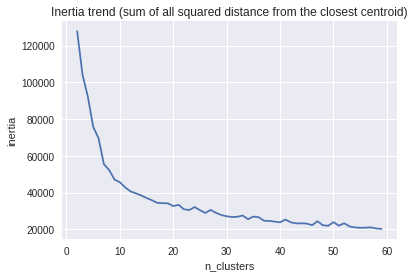

In [0]:
plt.plot([i[0] for i in inertia_log], [i[1] for i in inertia_log])
plt.ylabel('inertia')
plt.xlabel('n_clusters')
plt.title('Inertia trend (sum of all squared distance from the closest centroid)')
plt.show()

Silhouette trend.

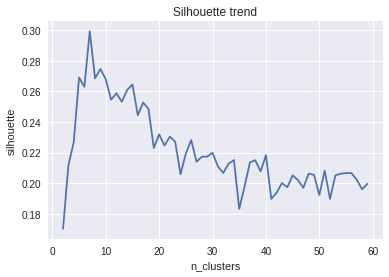

In [0]:
plt.plot([i[0] for i in sil_log], [i[1] for i in sil_log])
plt.ylabel('silhouette')
plt.xlabel('n_clusters')
plt.title('Silhouette trend')
plt.show()

In [0]:
n_clusters_users = 7 #@param {type:"slider", min:2, max:50, step:1}

We choose 7 clusters looking at the maximum of the silhouette trend. An higher number of clusters can be selected if a higher granularity resolution  is desired .

It follows the final clustering.

In [0]:
mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters_users, batch_size=100, # 80, 1000
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
# t0 = time()
mbk.fit(X_scaled)
# t_mini_batch = time() - t0
# print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

In [0]:
user_cluster = {}
cluster_occurrences = {i : 0 for i in range(n_clusters_users)}
cluster_samplesvec = {i : [] for i in range(n_clusters_users)}
cluster_samplescat = {i : [] for i in range(n_clusters_users)}
counter_vector = [5]*n_clusters_users

counter = 0
not_found_counter = 0
user_with_at_least_a_category = False

for i, user in enumerate(user_ids):
  cluster = mbk.labels_[i]
  user_cluster[user] = cluster
  cluster_occurrences[cluster] += 1
  if sum(counter_vector):
    if counter_vector[cluster]:
      cluster_samplesvec[cluster].append(X_scaled[i])
      cluster_samplescat[cluster].append((user_categories[user_ids[i]]))
      counter_vector[cluster] -= 1

In [0]:
print(dictionary_sample(user_cluster))

{'100000647': 3, '1000018933': 4, '100004020': 5, '100004272': 6, '1000042813': 2, '100005511': 1, '100006292': 5}


The clustering is balanced.

number of users 425145


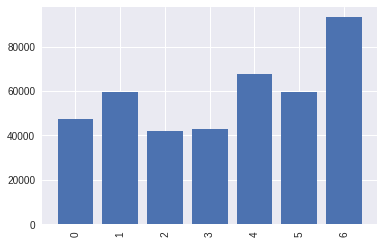

In [0]:
print('number of users', len(user_wikipages))
hist_from_dict(cluster_occurrences)

## 3. Associating S21 twitter users to the appropriate cluster of users

Using twitter API we obtained friendship information of the new users in S21.tsv. We stored this information in the `twuser_friends` dictionary, key: twitter userID, value: list of the IDs of the friends (who is followed by the user).

We can consider this problem as finding the best community (cluster) for each user, a reccomendation system where the data available for each user can be considered as a list of peers or as a list of interests.

At this point we have two choices to associate each user to a cluster:
1. **Collaborative approach.** If most of the friends are already tagged with a cluster (i.e. they are in `user_cluster` dictionary) we can simply assign to each user the cluster corresponding to the most frequent cluster among its friends. 
2. **Content based.** If the first method is not applicable, we should look at the friends as interests, collect the corresponding wikipages, parse in the above categories, normalize the category vectors and predict the cluster of each user using the already trained MiniBatch Kmeans model used in the clustering point.

First of all let's query the twitter API (or load our dictionary if we have built it before). 

We used tweepy, a common python library to deal with twitter API.

In [0]:
!pip install tweepy

    100% |████████████████████████████████| 286kB 14.7MB/s 
  Running setup.py bdist_wheel for PySocks ... - done
  Stored in directory: /content/.cache/pip/wheels/22/5c/b5/12e0dfdfa85bea67b23628b6425fae715c687e947a45ee3df9
Successfully built PySocks


Here you can choose to load or query the twitter APIs.

In [0]:
#SAVE/LOAD THINGS

load_S21 = True #@param {type:"boolean"}

import pickle
if load_S21:
  twuser_friends = pickle.load(open( "drive/Universita/Informatica/WebAndSocialInformationExtraction/project/S21.pickle", "rb" ))

In [0]:
# from pprint import pprint
# pprint(dictionary_sample(twuser_friends, n=2))
print(dictionary_sample(twuser_friends, n=2))
# print(sum([len(i) for i in twuser_friends.values()])/len(twuser_friends))
# print(sum([len(i) for i in twuser_friends1.values()])/len(twuser_friends1))
# pprint(twuser_friends1['1036702322'])
# pprint(twuser_friends['1036702322'])


{'10039022': [1392163634, 931618298659328001, 929544088730394624, 17915629, 18517310, 222196210, 45018198, 812004402252877824, 235236313, 1012109886, 2964986165, 195876694, 86905717, 49642583, 16382360, 17812282, 30009639, 1426645165, 19543987, 192613816, 99765242, 832420664619442176, 563957624, 26020351, 4692588938, 40358743, 3380757850, 868193804221808641, 115704886, 2587686432, 170782124, 824685119667666945, 185347378, 22279324, 13436452, 2853449164, 481943972, 76793189, 25916881, 15075999, 2341475005, 167155452, 50464559, 83732679, 127912207, 804737400, 499914568, 19407053, 751004822, 3421610433, 18188365, 24257941, 4374879508, 17994536, 16081399, 18637344, 27759041, 6655612, 722663234118033408, 365495044, 17982423, 22219473, 20402945, 14146300, 202396203, 287568380, 22708797, 55268034, 17770958, 18087749, 134207471, 456910776, 117759812, 3439402852, 1436355919, 15673837, 4265474673, 19297631, 23331132, 23226127, 17808233, 153770747, 124310360, 116471907, 15392391, 294813555, 93722

In [0]:
if not load_S21:

  import tweepy
  import random

  consumer_key = 'TOKEN'
  consumer_secret = 'TOKEN'
  access_token = 'TOKEN'
  access_token_secret = 'TOKEN'

  # OAuth process, using the keys and tokens
  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_token, access_token_secret)

  # Creation of the actual interface, using authentication. Use rate limits.
  api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

  screen_name = '----'
  file_name = 'drive/Universita/Informatica/WebAndSocialInformationExtraction/project/S21.tsv'
  with open(file_name) as f:
      ids = [x.strip() for x in f.readlines()]

  num_samples = 1500
  twuser_friends = dict()

  # Initialise i
  i = 0

  # We want to check that i is less than our number of samples, but we also need to make
  # sure there are IDs left to choose from.
  while i <= num_samples and ids:
      current_id = ids.pop()

      try:
          # try to get friends, and add them to our dictionary value if we can
          # use .get() to cope with the first loop.
          for page in tweepy.Cursor(api.friends_ids, current_id).pages():
              twuser_friends[current_id] = twuser_friends.get(current_id, []) + page
          i += 1
      except tweepy.TweepError:
          # we get a tweep error when we can't view a user - skip them and move onto the next.
          # don't increment i as we want to replace this user with someone else.
          print('Could not view user {}, skipping...'.format(current_id))
  pickle.dump(twuser_friends, open( "drive/Universita/Informatica/WebAndSocialInformationExtraction/project/S21_twfriends.pickle", "wb" ) )

check of the users, 78 of 1500 were not accessible.

In [0]:
print('number of users', len(twuser_friends))
print('average number of following for each user', np.mean([len(i) for i in twuser_friends.values()]))

number of users 1422
average number of following for each user 1129.3565400843881


#### Trying to find friends in user_cluster

Only 2% of friends have already a cluster, we should go for the longer way.

In [0]:
counter_found = 0
counter_not_found = 0
s21user_clustervec = {}

for key in twuser_friends:
  user_friendsclusters = [0] * n_clusters_users
  for friend in twuser_friends[key]:
    if str(friend) in user_cluster:
      counter_found += 1
      user_friendsclusters[user_cluster[str(friend)]] += 1
    else:
      counter_not_found += 1
  s21user_clustervec[key] = user_friendsclusters

print(counter_not_found / (counter_found + counter_not_found))
      

0.980475047401997


####Find interests of s21 users

First of all we check that a sufficient number of the friends, now viewed as interests, has a corresponding wikipage. 50% is not ideal but is sufficient considering that the average number of friends for each user is above 1000.

In [0]:
s21user_wikipages = {}
s21numberofinterests_occurrences = {i: 0 for i in range(1, 10000)}
s21missing_keys = {}
s21present_keys = {}

for counter, key in enumerate(twuser_friends):
  wikipages = []
  for interest in twuser_friends[key]:
    try:
      wikipages.append(interest_wiki[str(interest)])
      s21present_keys[key] = True
    except KeyError:
      s21missing_keys[key] = True
  if wikipages:    
    s21user_wikipages[key] = wikipages
    s21numberofinterests_occurrences[len(wikipages)] += 1

print('missing wikipages', len(s21missing_keys)/(len(s21missing_keys) + len(s21present_keys)))

missing wikipages 0.5007042253521127


Finding categories from wikipages.

In [0]:
s21user_categories = {}

counter = 0
not_found_counter = 0
user_with_at_least_a_category = False

for user in tqdm(s21user_wikipages):
  wikipages = s21user_wikipages[user]
  categories = [0] * n_clusters_cat
  for wikipage in wikipages:
    if wikipage in en_embedding_interests.w2idx:  # if the wikipage has a corresponding vector
      idcat = mbk_cat.labels_[en_embedding_interests.w2idx[wikipage]]
      categories[idcat] += 1
      counter += 1
      user_with_at_least_a_category = True
    else:
      not_found_counter += 1
  if user_with_at_least_a_category:
    s21user_categories[user] = np.array(categories)
  user_with_at_least_a_category = False

print("\nhow many times we don't have a vector for a wikipage", not_found_counter / (counter + not_found_counter))

100%|██████████| 1418/1418 [00:00<00:00, 11090.56it/s]


how many times we don't have a vector for a wikipage 0.1047461759950195


An overview of the data we are using.

In [0]:
print(dictionary_sample(twuser_friends))
print(dictionary_sample(interest_wiki))
print(dictionary_sample(s21user_wikipages))
print(dictionary_sample(s21user_categories))

{'10039022': [1392163634, 931618298659328001, 929544088730394624, 17915629, 18517310, 222196210, 45018198, 812004402252877824, 235236313, 1012109886, 2964986165, 195876694, 86905717, 49642583, 16382360, 17812282, 30009639, 1426645165, 19543987, 192613816, 99765242, 832420664619442176, 563957624, 26020351, 4692588938, 40358743, 3380757850, 868193804221808641, 115704886, 2587686432, 170782124, 824685119667666945, 185347378, 22279324, 13436452, 2853449164, 481943972, 76793189, 25916881, 15075999, 2341475005, 167155452, 50464559, 83732679, 127912207, 804737400, 499914568, 19407053, 751004822, 3421610433, 18188365, 24257941, 4374879508, 17994536, 16081399, 18637344, 27759041, 6655612, 722663234118033408, 365495044, 17982423, 22219473, 20402945, 14146300, 202396203, 287568380, 22708797, 55268034, 17770958, 18087749, 134207471, 456910776, 117759812, 3439402852, 1436355919, 15673837, 4265474673, 19297631, 23331132, 23226127, 17808233, 153770747, 124310360, 116471907, 15392391, 294813555, 93722

Normalizing the data.

In [0]:
s21X = np.array(list(s21user_categories.values()))
s21user_ids = np.array(list(s21user_categories.keys()))
s21X_scaled = preprocessing.normalize(s21X)

print(s21X_scaled.shape)
print(s21user_ids.shape)
print(s21X_scaled[0])

(1418, 41)
(1418,)
[0.07817631 0.01954408 0.01954408 0.03908816 0.01954408 0.
 0.05863223 0.         0.         0.01954408 0.         0.
 0.         0.27361709 0.         0.         0.11726447 0.
 0.11726447 0.27361709 0.         0.50814602 0.11726447 0.
 0.01954408 0.         0.23452893 0.27361709 0.         0.
 0.         0.         0.         0.01954408 0.46905786 0.
 0.41042563 0.13680854 0.         0.01954408 0.        ]


Finally finding the clusters.

In [0]:
s21user_cluster = {}
s21cluster_occurrences = {i : 0 for i in range(n_clusters_users)}
s21cluster_samplesvec = {i : [] for i in range(n_clusters_users)}
s21cluster_samplescat = {i : [] for i in range(n_clusters_users)}
counter_vector = [5]*n_clusters_users

counter = 0
not_found_counter = 0
user_with_at_least_a_category = False

for i, user in enumerate(s21user_ids):
  cluster = mbk.labels_[i]
  s21user_cluster[user] = cluster
  s21cluster_occurrences[cluster] += 1
  if sum(counter_vector):
    if counter_vector[cluster]:
      s21cluster_samplesvec[cluster].append(s21X_scaled[i])
      s21cluster_samplescat[cluster].append((s21user_categories[s21user_ids[i]]))
      counter_vector[cluster] -= 1

###Results

In [0]:
pprint(dictionary_sample(s21user_cluster))

{'100246585': 4,
 '10039022': 3,
 '100683053': 2,
 '1035612169': 5,
 '1041217416': 6,
 '105614185': 5,
 '105957588': 1}


If you want to check the cluster of a specific user

In [0]:
twitter_user_id = "100246585" #@param {type:"string"}
print('The user', twitter_user_id, 'has', 
      len(twuser_friends[twitter_user_id]), 
      'friends,', len(s21user_wikipages[twitter_user_id]), 
      'of them correspond to a wikipage.\nThe associated cluster is', 
      s21user_cluster[twitter_user_id])


The user 100246585 has 63 friends, 17 of them correspond to a wikipage.
The associated cluster is 4


## 4. Recommend to the 500 users of S23.tsv 3 out of the 6 proposed items
This final task requires the implementation of a recommender system. We have 500 twitter users with a list of their interests and we are requested to decide 3 new relevant interests for the user out of 6 proposed items. 

Considering all the work so far, which recommender system shall we use?

- A **Collaborative approach** is possible. We have community data, 425145 users each one with dozens of interests (see distribution in the histogram above in the [data preparation section](https://colab.research.google.com/drive/1QBNA4Atp6fnCV39EUGrvco93F6kh9WK6?authuser=1#scrollTo=IhnITINDsc4B)) among 216686 possible interests. However data is extremely sparse, every interest carries few information (it is only a 0/1, not a rating on 5 or 10) and does not make use of our knowledge engineering, the wikipedia embeddings.

- **Knowledge based approach**. Our knowledge engine has proved to be very powerful in the categorization task, where with "powerful" we refer to the high semanticity of the distance among embeddings, even after a dimensionality reduction (look for instance at[ Example of a user](https://colab.research.google.com/drive/1QBNA4Atp6fnCV39EUGrvco93F6kh9WK6?authuser=1#scrollTo=nEMAk18naS5J)). Using the embeddings we can build an item based recommender system of new generation, where the similarity between two items is simply given by the cosine similarity between the corresponding vectors. This approach is a clear step forward respect to the classic item based approach, embeddings encoding of relevant information about the item is enormously more effective and efficient than the standard hand crafted keywords. We have chosen this solution.



First of all we import the known interests for each of the 500 new users in s22user_wikipages.

In [0]:
s22user_wikipages = {}
maxnumberwikipages = 0

file_name = 'drive/Universita/Informatica/WebAndSocialInformationExtraction/project/S22_preferences.tsv'
with open(file_name) as f:
    for line in f:
      user, wikipage = line.split('\t')
      wikipage = wikipage[8:-1]
      if user in s22user_wikipages:
        s22user_wikipages[user].append(wikipage)
        if len(s22user_wikipages[user]) > maxnumberwikipages:
          maxnumberwikipages = len(s22user_wikipages[user])
      else:
        s22user_wikipages[user] = [wikipage]

How many interests for each user? It is useful to have an idea to tune future parameters.

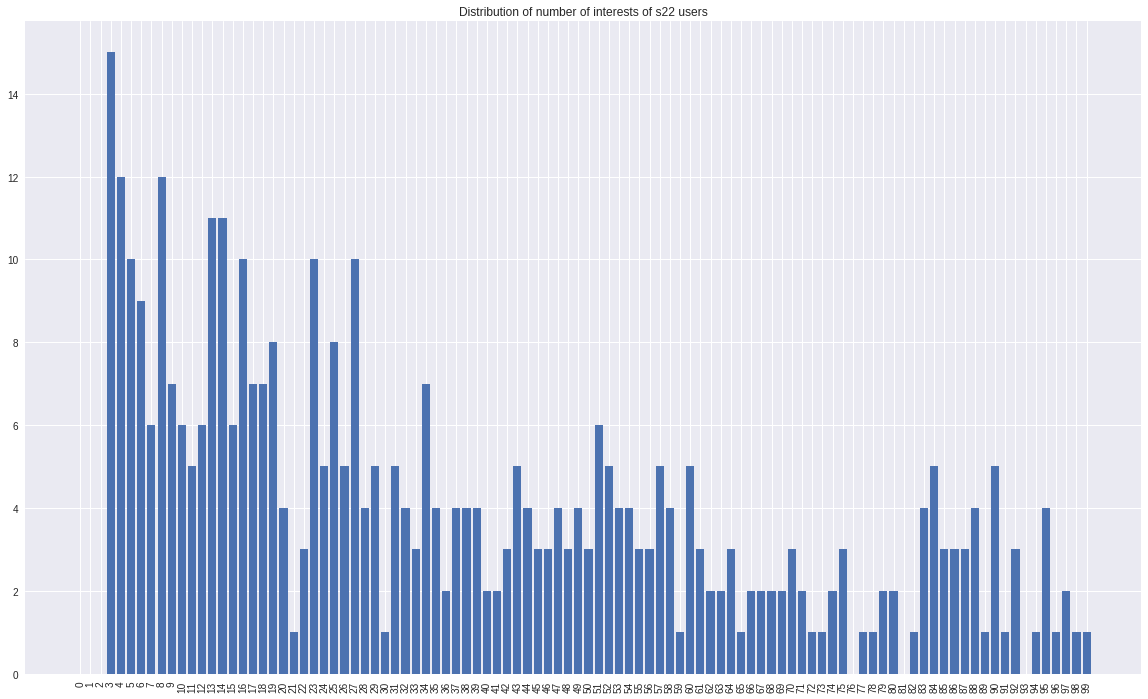

In [0]:
s22numberofinterests_occurrences = {i: 0 for i in range(100)} #range(maxnumberwikipages + 1)}

for user in s22user_wikipages:
  if len(s22user_wikipages[user]) in s22numberofinterests_occurrences:
    s22numberofinterests_occurrences[len(s22user_wikipages[user])] += 1

hist_from_dict(s22numberofinterests_occurrences, title='Distribution of number of interests of s22 users')

Now we import the 6 query wikipages for each user.

In [0]:
s22user_querywikipages = {}

file_name = 'drive/Universita/Informatica/WebAndSocialInformationExtraction/project/S23.tsv'
with open(file_name) as f:
    for line in f:
      user, wikipage = line.split('\t')
      wikipage = wikipage[8:-1]
      if user in s22user_querywikipages:
        s22user_querywikipages[user].append(wikipage)
      else:
        s22user_querywikipages[user] = [wikipage]

The only drawback of using the wikipedia embeddings is that some pages are missing, it is only a small percentage of the total but we have to  take this problem in consideration. While in the categorization task we could simply ignore those pages, here the risk is to have a missing page among the 6 to be ranked.

It is not very clear which type of page is missing, some are simply present but with little changes in the title name (especially special characters and disambiguation pages), other simply are not present.

Here we studied more in-depth which kind of page is missing, hoping the problem was the little changes in the title name in most of the cases (we could try to fix it) but unfortunately most of the problematic pages are simply missing.

In [0]:
def adjust_title(wikipage_notfound):
  maxlimit = 0
  for title in en_embedding.w2idx.keys():
    counter = 0
    for i, c in enumerate(title):
      if c != wikipage_notfound[i]:
        if counter > maxlimit:
          newtitle = title
          maxlimit = counter
        break
      else:
        counter += 1
        if i == (len(wikipage_notfound) - 1):
          newtitle = title
          break
  return newtitle
    

Out of 10 only Citytv_Bogot�has a consistent substitute.

We will ignore missing wikipages also in this task.

In [0]:
for counter, user in enumerate(s22user_querywikipages):
  for page in s22user_querywikipages[user]:
    try:
      en_embedding.wiki_vector(page)
    except KeyError:
      if counter < 10:
        print('MISSING PAGE:', page, '\tPOSSIBLE SUBSTITUTE:', adjust_title(page))
        counter += 1
      else:
        break
    if counter > 9:
      break

MISSING PAGE: Mix_Up 	POSSIBLE SUBSTITUTE: Mix_Master_Mike
MISSING PAGE: OCESA_Seitrack 	POSSIBLE SUBSTITUTE: OCLC
MISSING PAGE: Citytv_Bogot� 	POSSIBLE SUBSTITUTE: Citytv_BogotÃ¡
MISSING PAGE: Radioshow 	POSSIBLE SUBSTITUTE: Radiosurgery
MISSING PAGE: E3 	POSSIBLE SUBSTITUTE: E331_series
MISSING PAGE: Cut_Memey 	POSSIBLE SUBSTITUTE: Cut_Me_Some_Slack
MISSING PAGE: Muy_Interesante 	POSSIBLE SUBSTITUTE: Muy_Dentro_de_Mi_CorazÃ³n
MISSING PAGE: Jornal_Hoje 	POSSIBLE SUBSTITUTE: Jornal_Nacional
MISSING PAGE: Susie_Cagle 	POSSIBLE SUBSTITUTE: Susie_Castillo


### Ranking pages
Here it is performed the ranking, we are going to assign a score to each one of the 6 proposed wikipages and we will choose the best 3. 

Take a user $u$, indicating with $q_1 ... q_6$ its query wikipages, let $I_{u,q_i}  = \{i_{q_i1} \,...\, i_{q_i10}\}$ be the set of the 10 pages more similiar to $q_i$ among $u$ interest wikipages. The score for each page $q_i$ is:
$$score(q_i) = \sum_j cossim(q_i, i_{q_ij})$$

$I_{u,q_i} $ may have less than $10$ elements if the user $u$ has less than $10$ interests or if there are less than $10$ interests over the similarity threshold of $0.1$.

The parameters $10$ (number of interests considered) and $0.1$ (similarity threshold) were chosen after some tuning and taking in consideration the number of interests per user.

We decided not to make a normalization of the scores since we considered informative a lower score due to few elements in $I_{u,q_i} $. This makes possible a comparison between page scores of different users.

We saved the results in the file S24.tsv. A sample of the results is showed in output, it is possible to choose the size of the sample.



In [0]:
rankings_showed = 10 #@param {type:"slider", min:0, max:500, step:1}

In [0]:
counter_NOTFOUND = 0

file_name = 'drive/Universita/Informatica/WebAndSocialInformationExtraction/project/S24.tsv'
with open(file_name, 'w+') as f:
  for counter, user in enumerate(s22user_wikipages):
    if counter <= rankings_showed:
      print('USER', user)
      print('interested in', len(s22user_wikipages[user]), 'wikipages')
  #   print(s22user_querywikipages[user] + s22user_wikipages[user])
      en_embedding_s22user = WikiEmbedding(preset = wikiembedding_from_wikipages(s22user_wikipages[user], en_embedding, verbose=1)) #s22user_querywikipages[user] + 
    en_embedding_s22user = WikiEmbedding(preset = wikiembedding_from_wikipages(s22user_wikipages[user], en_embedding, verbose=0)) #s22user_querywikipages[user] + 
  #   print(en_embedding_s22user.w2idx)
  #   break
    rating_querywikipage = {}
    querywikipage_mostsimilar = {}
    notfound_pages = []
    for querywikipage in s22user_querywikipages[user]:
      try:
        mostsimilar = en_embedding_s22user.most_similar(en_embedding.wiki_vector(querywikipage), n=10, min_similarity=0.1)
        rating_querywikipage[round(sum([element[1] for element in mostsimilar]), 3)] = querywikipage
        querywikipage_mostsimilar[querywikipage] = mostsimilar
      except KeyError:
        notfound_pages.append(querywikipage)
  #       print('\n###', querywikipage, 'NOT FOUND')
  #       print('###', adjust_title(querywikipage), 'SUBST\n')
        counter_NOTFOUND += 1
    ranking = sorted(rating_querywikipage, reverse=True)
    
    for i, rank in enumerate(ranking):
      if i < 3:
        f.write(user + '\tWIKI:EN:' + rating_querywikipage[rank] + '\n')
    if counter <= rankings_showed:
      print('\n---- RATING OF THE 6 NEW PAGES ----')
      for i, rank in enumerate(ranking):
        if i < 3:
          print(rank, '✓', rating_querywikipage[rank])
        else:
          print(rank, '✖', rating_querywikipage[rank])
      for wikipage in notfound_pages:
        print('----- ⚠', wikipage, 'NOT FOUND')
    if counter == 0:
      print('\n\nWhich wikipages are considered and with which weight for each of the 6 query_wikipages')
      for rank in ranking:
        print('\n', rating_querywikipage[rank])
        pprint(querywikipage_mostsimilar[rating_querywikipage[rank]])
    if counter <= rankings_showed:
      print('----------------------------------------------------------------------------------------------')

  print('END OF THE SAMPLE\n----------------------------------------------------------------------------------------------')
  print(counter_NOTFOUND, 'querywikipages not found ', str(round(counter_NOTFOUND/30, 2)) + '% of the total')

USER 101935414
interested in 26 wikipages
0.04 fraction of pages not found ( 1 )

---- RATING OF THE 6 NEW PAGES ----
5.285 ✓ Shinichi_Osawa
4.462 ✓ Gilles_Peterson
4.007 ✓ Peter_Barakan
2.943 ✖ Bonnie_Bernstein
2.935 ✖ Kevin_Davies
2.832 ✖ Kyle_Lohse


Which wikipages are considered and with which weight for each of the 6 query_wikipages

 Shinichi_Osawa
[('Ninja_Tune', 0.6663292170881343),
 ('Yukihiro_Takahashi', 0.6424594410477666),
 ('Daoko', 0.6243284984447226),
 ('Zeebra', 0.5820755131695081),
 ('Gackt', 0.544863737228695),
 ('Mixcloud', 0.467088059263876),
 ('The_Japan_Times', 0.4661379830185589),
 ('Yoshitomo_Nara', 0.4575203441516214),
 ('SoundCloud', 0.42111234639628636),
 ('Rinko_Kikuchi', 0.4126845328623697)]

 Gilles_Peterson
[('Ninja_Tune', 0.7252076808506879),
 ('Mixcloud', 0.5316146964255084),
 ('Nina_Kraviz', 0.5082883518227227),
 ('SoundCloud', 0.47402101193394264),
 ('Yukihiro_Takahashi', 0.46656112756863005),
 ('Daoko', 0.40280916617172213),
 ('Zeebra', 0.3940493777

# Conclusions

We have created a multi-domain social reccomendation system based on the WIKI_MID dataset and using Wikipedia embeddings as semantic model. 

We have completed all tasks with success. Our approach was effective, the only problem was the incompleteness of our data (missing wikipages both in the WIKI_MID dataset and in the Wikipedia embeddings) that affected particularly the last point.  



